In [141]:
%matplotlib ipympl

In [142]:
from cesnet_datazoo.datasets import CESNET_QUIC22, CESNET_TLS22
from cesnet_datazoo.config import DatasetConfig

dataset = CESNET_QUIC22(data_root="data/CESNET_QUIC22/", size="XS", silent=True)

dataset_config = DatasetConfig(
    dataset=dataset,
    train_period_name="W-2022-44",
    train_size=100_000,
    use_packet_histograms=True,
)
dataset.set_dataset_config_and_initialize(dataset_config)

data_df = dataset.get_train_df()

data_df.columns

Index(['PPI', 'BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 'DURATION',
       'PPI_LEN', 'PPI_ROUNDTRIPS', 'PPI_DURATION', 'FLOW_ENDREASON_IDLE',
       'FLOW_ENDREASON_ACTIVE', 'FLOW_ENDREASON_OTHER', 'PSIZE_BIN1',
       'PSIZE_BIN2', 'PSIZE_BIN3', 'PSIZE_BIN4', 'PSIZE_BIN5', 'PSIZE_BIN6',
       'PSIZE_BIN7', 'PSIZE_BIN8', 'PSIZE_BIN1_REV', 'PSIZE_BIN2_REV',
       'PSIZE_BIN3_REV', 'PSIZE_BIN4_REV', 'PSIZE_BIN5_REV', 'PSIZE_BIN6_REV',
       'PSIZE_BIN7_REV', 'PSIZE_BIN8_REV', 'IPT_BIN1', 'IPT_BIN2', 'IPT_BIN3',
       'IPT_BIN4', 'IPT_BIN5', 'IPT_BIN6', 'IPT_BIN7', 'IPT_BIN8',
       'IPT_BIN1_REV', 'IPT_BIN2_REV', 'IPT_BIN3_REV', 'IPT_BIN4_REV',
       'IPT_BIN5_REV', 'IPT_BIN6_REV', 'IPT_BIN7_REV', 'IPT_BIN8_REV', 'APP'],
      dtype='object')

In [143]:
import numpy as np

features_to_extract = ["BYTES", "BYTES_REV", "PACKETS", "PACKETS_REV", "DURATION"]

features_app_df = data_df.copy(True)[[*features_to_extract, "APP"]]

features_app_df[["APP_NAME"]] = None
features_app_df["APP_NAME"] = features_app_df["APP"].apply(lambda x: dataset._tables_app_enum.get(x, "Unknown"))

transformers for extracting embeddings

In [144]:
# save only 200 samples per app and remove other samples

features_app_df = features_app_df.groupby("APP_NAME").head(200)
features_app_df = features_app_df.reset_index(drop=True)

features_app_df[["APP_NAME"]].value_counts()

APP_NAME             
youtube                  200
overleaf-compile         200
fitbit                   200
medium                   200
fontawesome              200
                        ... 
ebay-kleinanzeigen         9
instagram                  9
google-authentication      9
google-autofill            8
uber                       7
Name: count, Length: 101, dtype: int64

In [145]:
# new features

new_features = ["BYTES_PER_PACKET", "BYTES_PER_PACKET_REV", "BYTES_TOTAL", "PACKETS_TOTAL"]
new_features_df = features_app_df.copy(True)

new_features_df["BYTES_PER_PACKET"] = new_features_df["BYTES"] / new_features_df["PACKETS"]
new_features_df["BYTES_PER_PACKET_REV"] = new_features_df["BYTES_REV"] / new_features_df["PACKETS_REV"]
# new_features_df["PACKETS_PER_SECOND"] = new_features_df["PACKETS"] / new_features_df["DURATION"]
# new_features_df["PACKETS_PER_SECOND_REV"] = new_features_df["PACKETS_REV"] / new_features_df["DURATION"]
new_features_df["BYTES_TOTAL"] = new_features_df["BYTES"] + new_features_df["BYTES_REV"]
new_features_df["PACKETS_TOTAL"] = new_features_df["PACKETS"] + new_features_df["PACKETS_REV"]

In [146]:
features_app_df = new_features_df
features_to_extract.extend(new_features)

In [147]:
# alza-webapi, instagram, flightradar24, dns-doh, facebook-media

features_app_df = features_app_df[features_app_df["APP_NAME"].isin(["alza-webapi", "drmax", "dns-doh", "flightradar24"])]

features_array = features_app_df[features_to_extract].to_numpy()

app_array = features_app_df["APP_NAME"].to_numpy()

In [164]:
features_app_df.to_csv("data/features_app_df.csv", index=False)

In [162]:
features_app_df.head()

,BYTES,BYTES_REV,PACKETS,PACKETS_REV,DURATION,APP,APP_NAME,BYTES_PER_PACKET,BYTES_PER_PACKET_REV,BYTES_TOTAL,PACKETS_TOTAL
7,17441.0,1871826.0,131.0,1547.0,310.725616,66,flightradar24,133.137405,1209.971558,1889267.0,1678.0
22,3001.0,2942.0,7.0,9.0,0.184786,66,flightradar24,428.714294,326.888885,5943.0,16.0
28,125051.0,14803393.0,1370.0,11945.0,38.359341,66,flightradar24,91.278099,1239.296143,14928444.0,13315.0
47,40347.0,243395.0,122.0,300.0,37.789391,66,flightradar24,330.713104,811.316650,283742.0,422.0
57,36983.0,7747.0,63.0,44.0,23.289654,66,flightradar24,587.031738,176.068176,44730.0,107.0


In [149]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    # ('pca', PCA(n_components=2)),
    # ('tsne', TSNE(n_components=2, random_state=42)),
    # ('kpca', KernelPCA(n_components=2, kernel='rbf', random_state=42)),
])

preprocessed_array = preprocessing_pipeline.fit_transform(features_array)

In [165]:
print(features_array.shape)

(639, 9)


In [150]:
from sklearn.cluster import KMeans

models_array = []

for i in range(4, 12):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(preprocessed_array)
    models_array.append(kmeans)

C:\Users\nikol\miniconda3\envs\bachelors-diploma\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\nikol\miniconda3\envs\bachelors-diploma\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\nikol\miniconda3\envs\bachelors-diploma\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\nikol\miniconda3\envs\bachelors-diploma\Lib\site-packag

In [151]:
from sklearn.mixture import GaussianMixture

gmm_array = []

for i in range(4, 12):
    gmm = GaussianMixture(n_components=i, random_state=42)
    gmm.fit(preprocessed_array)
    gmm_array.append(gmm)

C:\Users\nikol\miniconda3\envs\bachelors-diploma\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\nikol\miniconda3\envs\bachelors-diploma\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\nikol\miniconda3\envs\bachelors-diploma\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\nikol\miniconda3\envs\bachelors-diploma\Lib\site-packag

In [152]:
from sklearn.metrics.cluster import contingency_matrix

def purity_score(y_true, y_pred) -> float:
    """
    Calculate the purity score for a clustering result.

    The purity score is a metric to evaluate the quality of a clustering result.
    It measures the extent to which clusters contain only a single class.
    Args:
        y_true (ArrayLike): The true labels of the samples.
        y_pred (ArrayLike): The predicted labels of the samples.
    Returns:
        float: The purity score.
    """

    cm = contingency_matrix(y_true, y_pred)

    return float(np.sum(np.amax(cm, axis=0)) / np.sum(cm))

In [153]:
for i, model in enumerate(models_array):
    print(f"Model {i + 4} clusters: {purity_score(app_array, model.labels_)}")

Model 4 clusters: 0.5665101721439749
Model 5 clusters: 0.564945226917058
Model 6 clusters: 0.5774647887323944
Model 7 clusters: 0.6181533646322379
Model 8 clusters: 0.5790297339593115
Model 9 clusters: 0.6181533646322379
Model 10 clusters: 0.5743348982785602
Model 11 clusters: 0.6306729264475743


In [154]:
for i, model in enumerate(gmm_array):
    print(f"Model {i + 4} clusters: {purity_score(app_array, model.predict(preprocessed_array))}")

Model 4 clusters: 0.4444444444444444
Model 5 clusters: 0.5602503912363067
Model 6 clusters: 0.5790297339593115
Model 7 clusters: 0.5633802816901409
Model 8 clusters: 0.5805946791862285
Model 9 clusters: 0.6369327073552425
Model 10 clusters: 0.5712050078247262
Model 11 clusters: 0.651017214397496


In [155]:
# homogeneity score, completeness score, v-measure score

from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score

for i, model in enumerate(models_array):
    print(f"Model {i + 4} clusters: {homogeneity_score(app_array, model.labels_)}")
    print(f"Model {i + 4} clusters: {completeness_score(app_array, model.labels_)}")
    print(f"Model {i + 4} clusters: {v_measure_score(app_array, model.labels_)}")

Model 4 clusters: 0.2524761743300579
Model 4 clusters: 0.41187925846934065
Model 4 clusters: 0.31305441132936385
Model 5 clusters: 0.25611625305404545
Model 5 clusters: 0.3248006563669629
Model 5 clusters: 0.2863980226745755
Model 6 clusters: 0.26832738398701694
Model 6 clusters: 0.3064339078908362
Model 6 clusters: 0.28611741963563114
Model 7 clusters: 0.3042661915044608
Model 7 clusters: 0.29934805458409725
Model 7 clusters: 0.30178708701056695
Model 8 clusters: 0.2766230041691059
Model 8 clusters: 0.30320625111200017
Model 8 clusters: 0.2893052508183329
Model 9 clusters: 0.3286824026516761
Model 9 clusters: 0.28883030212980737
Model 9 clusters: 0.3074703951110716
Model 10 clusters: 0.31055071646761623
Model 10 clusters: 0.24992025936043397
Model 10 clusters: 0.27695605642910764
Model 11 clusters: 0.3604921756317905
Model 11 clusters: 0.26285963216896685
Model 11 clusters: 0.3040300501274905


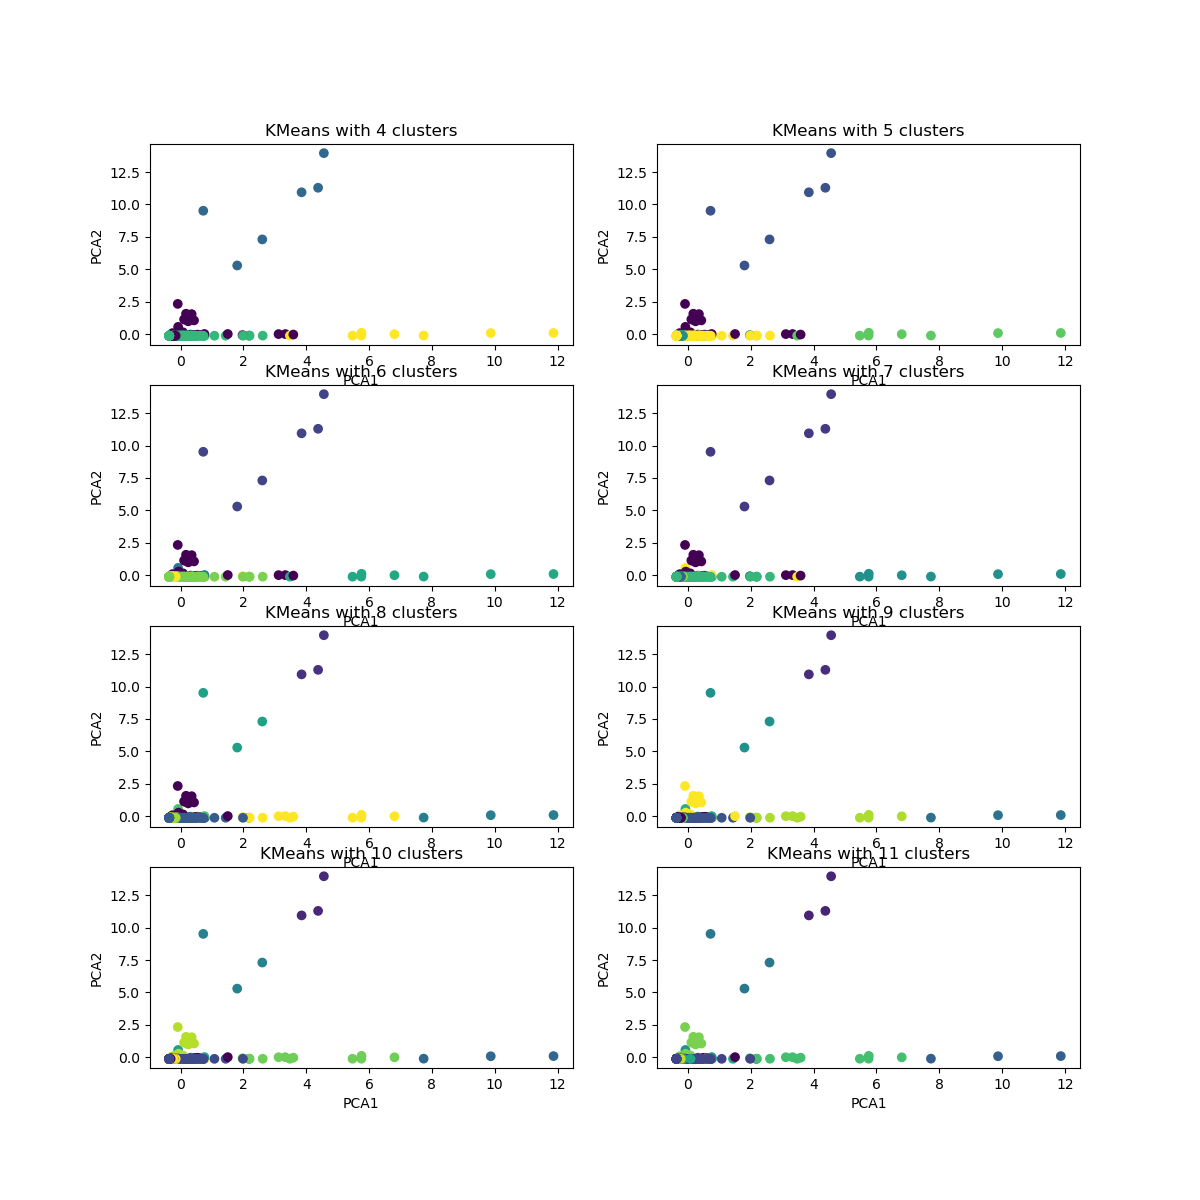

In [156]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

for i, model in enumerate(models_array):
    plt.subplot(4, 2, i + 1)
    plt.scatter(preprocessed_array[:, 0], preprocessed_array[:, 1], c=model.labels_, cmap='viridis')
    plt.title(f"KMeans with {model.n_clusters} clusters")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    
#plt.tight_layout()
plt.show()

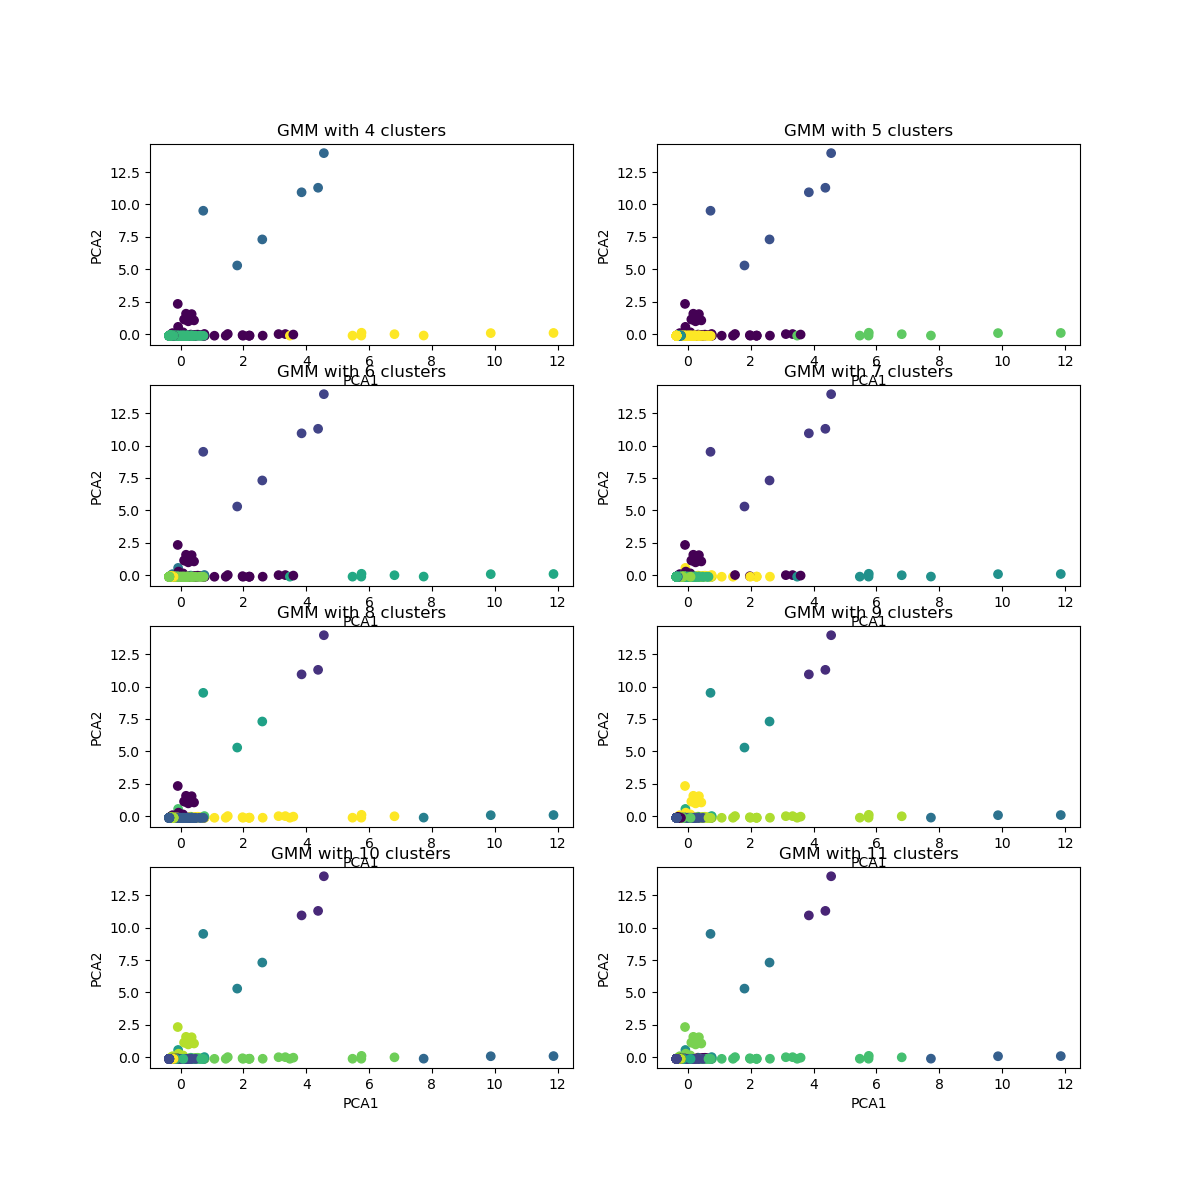

In [157]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# show GMM
for i, model in enumerate(gmm_array):
    plt.subplot(4, 2, i + 1)
    plt.scatter(preprocessed_array[:, 0], preprocessed_array[:, 1], c=model.predict(preprocessed_array), cmap='viridis')
    plt.title(f"GMM with {model.n_components} clusters")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    
plt.show()

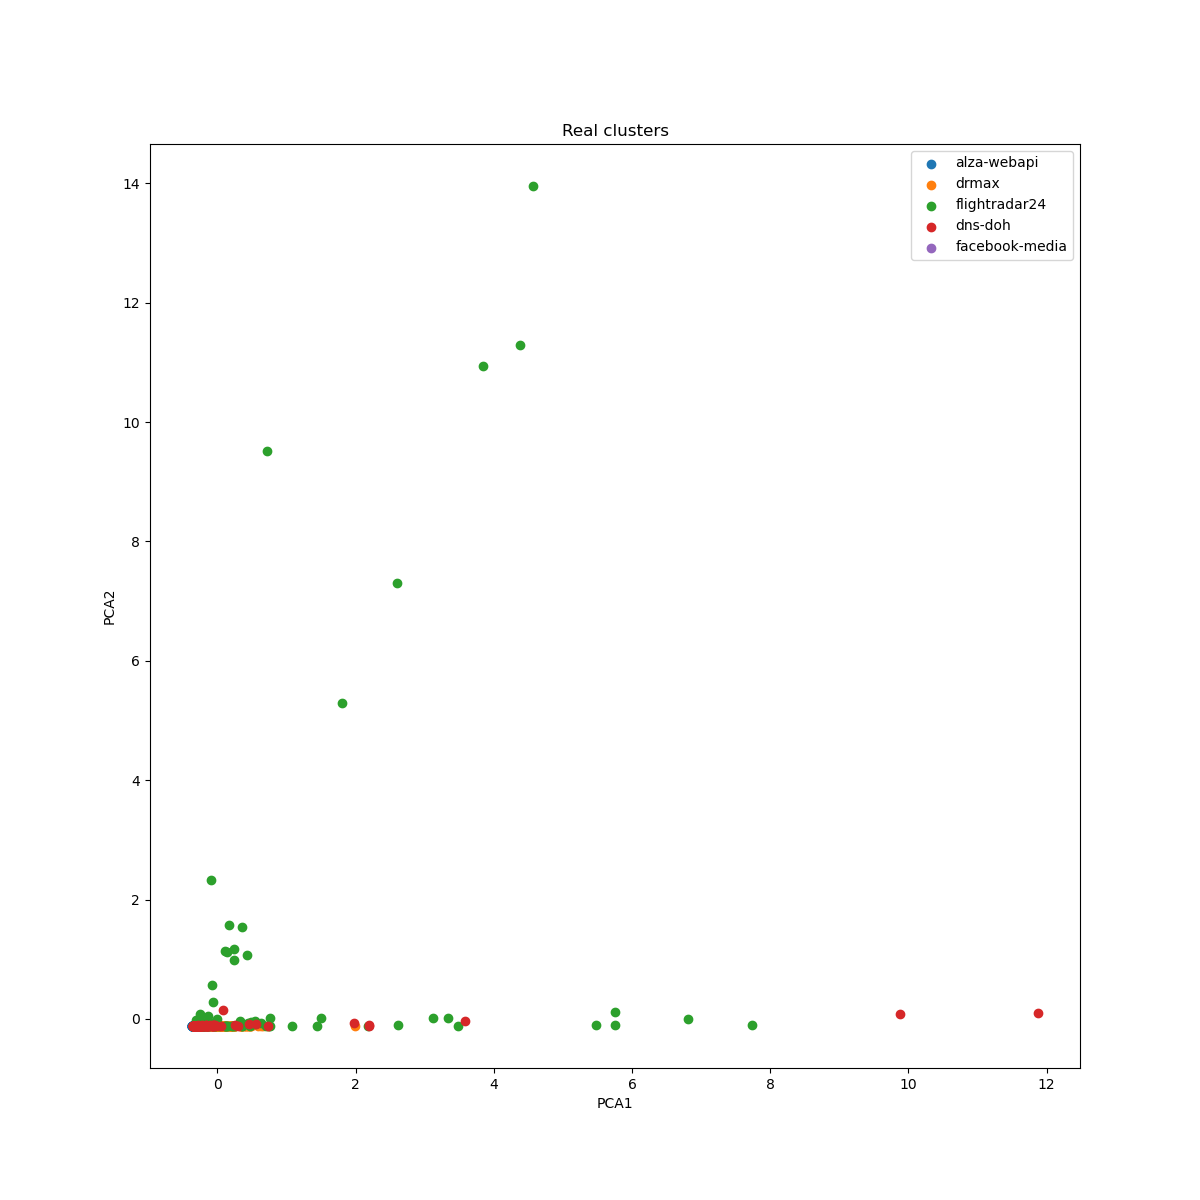

In [158]:
# real clusters: 5

plt.figure(figsize=(12, 12))
    
plt.scatter(preprocessed_array[app_array == "alza-webapi", 0], preprocessed_array[app_array == "alza-webapi", 1], c='tab:blue', label="alza-webapi")
plt.scatter(preprocessed_array[app_array == "drmax", 0], preprocessed_array[app_array == "drmax", 1], c='tab:orange', label="drmax")
plt.scatter(preprocessed_array[app_array == "flightradar24", 0], preprocessed_array[app_array == "flightradar24", 1], c='tab:green', label="flightradar24")
plt.scatter(preprocessed_array[app_array == "dns-doh", 0], preprocessed_array[app_array == "dns-doh", 1], c='tab:red', label="dns-doh")
plt.scatter(preprocessed_array[app_array == "facebook-media", 0], preprocessed_array[app_array == "facebook-media", 1], c='tab:purple', label="facebook-media")

#legend
plt.legend()

plt.title("Real clusters")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()